<a href="https://colab.research.google.com/github/JuliMillan/Series-temporales/blob/main/Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import mean_squared_error
import plotly.express as px
!pip install statsmodels --upgrade
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import datetime
from statsmodels.tsa.arima_model import ARMA, ARIMA
import warnings 
warnings.filterwarnings('ignore')
!pip install pmdarima
from pmdarima import auto_arima

In [2]:
df = # ingresar path del archivo

##Funciones para graficar

In [3]:
def count_plot_vertical(columna1, columna2, df,paleta=sns.color_palette(), 
                        xlabel='', ylabel='Cantidad', tamano=(6,6),
                        title='', pad=-60):
  """
  columna1: df['columna1']
  columna2: "columna"
  """
  orden=columna1.value_counts().index
  total=columna1.count()
  fig, ax = plt.subplots(figsize=tamano)
  sns.countplot(x=columna2, data=df, palette=paleta, order=orden)
  #Para mostrar los valores sobre las barras verticales
  for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()
    value = "{:.1f}%".format((int(p.get_height())*100)/total) # porcentaje
    ax.text(_x, _y, value, ha="center") 
  plt.xlabel('{}'.format(xlabel))
  plt.ylabel('{}'.format(ylabel))
  ax.set_yticklabels([])
  ax.set_title(title, fontsize=20, loc='Center', y=1,  pad=pad)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  return plt.show()


def horizontal(x, y, data, sort, xlabel='', ylabel=''):
  """
  Gráfico de barras horizontales
  """
  fig, ax = plt.subplots(figsize=(15,8))
  sns.barplot(x=x, y=y, data=data.sort_values(sort, ascending=False))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return plt.show()


def mas_vendidas_provincia(provincia):

  a_p = a_2.unstack()
  aa = pd.DataFrame(a_p.loc[provincia]).reset_index()
  aa = aa.drop(columns=['level_0'])
  aa.columns = ['BRAND', 'Sales ARS']
  aa = (aa.sort_values(by='Sales ARS', ascending=False)).head(10)
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.barplot(x='BRAND', y='Sales ARS', data=aa, palette='magma')
  plt.xticks(rotation=90)
  plt.xlabel('Marcas')
  plt.ylabel('Ventas en ARS')
  plt.title("Marcas más vendidas en "+'{}'.format(provincia), fontdict = {'fontsize' : 24})

  return plt.show()

## Exploración de los datos

In [4]:
df.head()

,Year,Month,Segment,Subsegment,BRAND,SYSTEM,PROVINCE,RETAILER,Sales Units,Th. Sales Value USD,Th. Sales Value ARS
0,2017,January,A,01,BRAND-1,Old,BUENOS AIRES,F,912.645,483.412463,7702.772260
1,2017,February,A,01,BRAND-1,Old,BUENOS AIRES,F,786.420,413.161071,6511.058545
2,2017,March,A,01,BRAND-1,Old,BUENOS AIRES,F,508.110,277.760285,4293.800075
3,2017,April,A,01,BRAND-1,Old,BUENOS AIRES,F,589.175,323.879777,4994.754164
4,2017,May,A,01,BRAND-1,Old,BUENOS AIRES,F,441.900,234.857981,3585.849960


In [5]:
df.columns

Index(['Year', 'Month', 'Segment', 'Subsegment', 'BRAND', 'SYSTEM', 'PROVINCE',
       'RETAILER', 'Sales Units', 'Th. Sales Value USD',
       'Th. Sales Value ARS'],
      dtype='object')

In [6]:
df.columns = ['Year', 'Month', 'Segment', 'Subsegment', 'BRAND', 'SYSTEM', 'PROVINCE',
       'RETAILER', 'Sales Units', 'Sales USD',
       'Sales ARS']

In [7]:
df.shape

(256853, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256853 entries, 0 to 256852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Year         256853 non-null  int64  
 1   Month        256853 non-null  object 
 2   Segment      256853 non-null  object 
 3   Subsegment   256853 non-null  object 
 4   BRAND        256853 non-null  object 
 5   SYSTEM       256853 non-null  object 
 6   PROVINCE     256853 non-null  object 
 7   RETAILER     256853 non-null  object 
 8   Sales Units  256853 non-null  float64
 9   Sales USD    256853 non-null  float64
 10  Sales ARS    256853 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 21.6+ MB


In [9]:
df.describe()

,Year,Sales Units,Sales USD,Sales ARS
count,256853.000000,256853.000000,256853.000000,256853.000000
mean,2018.489817,15.734743,10.418320,406.165777
std,1.206668,54.436726,34.268073,1554.217185
min,2017.000000,-136.230000,-66.261423,-3831.257586
25%,2017.000000,1.500000,0.969474,29.948445
50%,2018.000000,3.105000,2.545359,85.588651
75%,2020.000000,10.500000,7.396908,264.584175
max,2021.000000,2927.535000,2066.790594,117362.296844


In [10]:
print(df['Year'].min(), '-', df['Year'].max())

2017 - 2021


In [11]:
df[['Year', 'Month']]

,Year,Month
0,2017,January
1,2017,February
2,2017,March
3,2017,April
4,2017,May
...,...,...
256848,2021,February
256849,2021,February
256850,2021,February
256851,2021,February


In [12]:
df[df.Year==2021].Month.unique()
#Para el 2021 tengo sóólo los dos primeros meses

array(['January', 'February'], dtype=object)

### Ventas totales

Unidades vendidas

In [13]:
unidades = pd.DataFrame(df.groupby('PROVINCE').agg({'Sales Units': 'sum'}).reset_index()).sort_values(by='Sales Units', ascending=False)
unidades.head()

,PROVINCE,Sales Units
4,CAP. FED. Y GBA,683758.878110
18,NO REG SPLIT AR,515088.751599
2,BUENOS AIRES,411185.441346
8,CORDOBA,324518.617043
24,SANTA FE,259429.868595


In [14]:
fig = px.bar(unidades, x="Sales Units", y="PROVINCE", orientation='h',color="PROVINCE", height=600)
fig.update_layout(showlegend=False)
fig.show()

In [15]:
ventas_totales = pd.DataFrame(df.groupby('PROVINCE').agg({'Sales ARS': 'sum'}).reset_index())
ventas_totales.head()

,PROVINCE,Sales ARS
0,BS.AS. GBA,8.728927e+06
1,BS.AS. INTERIOR,7.226350e+06
2,BUENOS AIRES,7.456318e+06
3,CABA ARGENTINA,4.759194e+06
4,CAP. FED. Y GBA,1.039053e+07


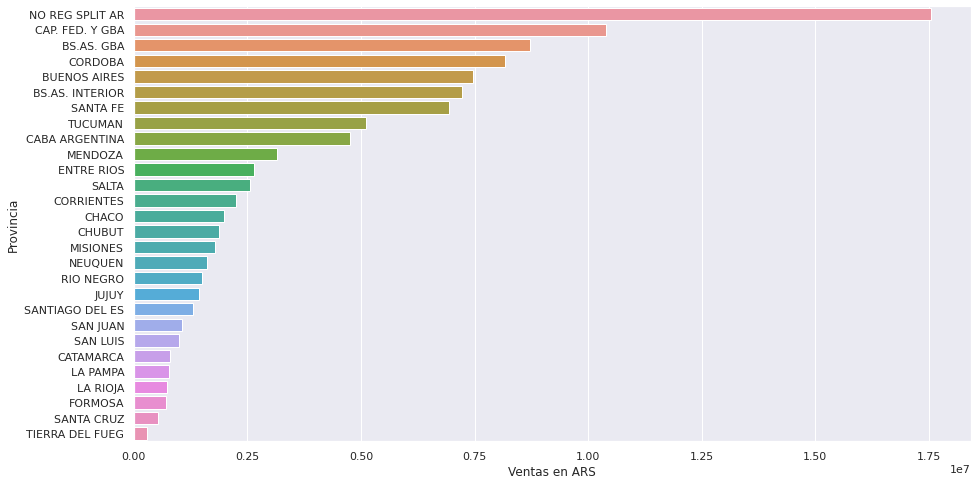

In [16]:
horizontal("Sales ARS", "PROVINCE", ventas_totales, 
           'Sales ARS', 'Ventas en ARS', 'Provincia')

In [17]:
#fig, ax = plt.subplots(figsize=(15,8))
#sns.barplot(x="Sales ARS", y="PROVINCE", 
#            data=ventas_totales.sort_values('Sales ARS', 
#                                           ascending=False))
#plt.xlabel('Ventas en ARS')
#plt.ylabel('Provincia')
#plt.show()

In [18]:
#Le saco el 'No reg split ar'
df = df[df['PROVINCE'] != 'NO REG SPLIT AR']
ventas_ars = pd.DataFrame(df.groupby('PROVINCE').agg({'Sales ARS': 'sum'}).reset_index())

In [19]:
prov = df['PROVINCE'].unique()
prov

array(['BUENOS AIRES', 'CAP. FED. Y GBA', 'CATAMARCA', 'CHACO', 'CHUBUT',
       'CORDOBA', 'ENTRE RIOS', 'LA PAMPA', 'LA RIOJA', 'MENDOZA',
       'MISIONES', 'NEUQUEN', 'RIO NEGRO', 'SAN JUAN', 'SAN LUIS',
       'SANTA CRUZ', 'SANTA FE', 'SANTIAGO DEL ES', 'CORRIENTES',
       'FORMOSA', 'JUJUY', 'SALTA', 'TUCUMAN', 'TIERRA DEL FUEG',
       'CABA ARGENTINA', 'BS.AS. GBA', 'BS.AS. INTERIOR'], dtype=object)

In [20]:
#horizontal("Sales ARS", "PROVINCE", ventas_ars, 
#           'Sales ARS', 'Ventas en ARS', 'Provincias')

In [21]:
v_a = ventas_ars.sort_values(by='Sales ARS', ascending=False)

In [22]:
fig = px.bar(v_a, x="Sales ARS", y="PROVINCE", orientation='h',color="PROVINCE", height=600)
fig.update_layout(showlegend=False)
fig.show()

In [23]:
ventas_dolares = pd.DataFrame(df.groupby('PROVINCE').agg({'Sales USD': 'sum'}).reset_index())
ventas_dolares.head()

,PROVINCE,Sales USD
0,BS.AS. GBA,123517.083340
1,BS.AS. INTERIOR,101262.860496
2,BUENOS AIRES,271545.824530
3,CABA ARGENTINA,82220.397862
4,CAP. FED. Y GBA,481598.532667


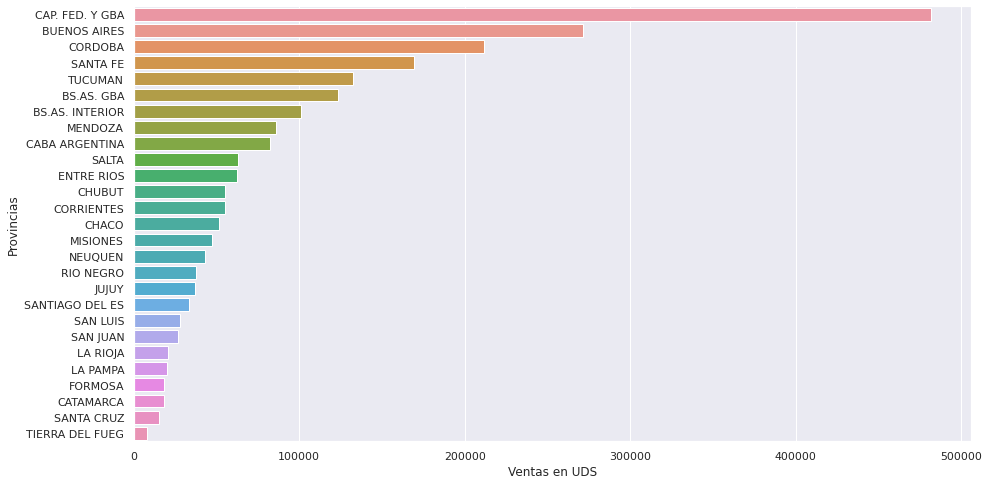

In [24]:
horizontal("Sales USD", "PROVINCE", ventas_dolares, 
           'Sales USD', 'Ventas en UDS', 'Provincias')

In [25]:
df['Segment'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object)

In [26]:
df['Subsegment'].unique()

array(['01', '04', '03', '02', '05', 'OTHERS'], dtype=object)

In [27]:
df['BRAND'].unique()

array(['BRAND-1', 'BRAND-2', 'BRAND-3', 'BRAND-4', 'BRAND-5', 'BRAND-6',
       'BRAND-7', 'BRAND-8', 'BRAND-9', 'BRAND-10', 'BRAND-11',
       'BRAND-12', 'BRAND-13', 'BRAND-14', 'BRAND-15', 'BRAND-16',
       'BRAND-17', 'BRAND-18', 'BRAND-19', 'BRAND-20', 'BRAND-21',
       'BRAND-22', 'BRAND-23', 'BRAND-24', 'BRAND-25', 'BRAND-26',
       'BRAND-27', 'BRAND-28', 'BRAND-29', 'BRAND-30', 'BRAND-31',
       'BRAND-32', 'BRAND-33', 'BRAND-34', 'BRAND-35', 'BRAND-36',
       'BRAND-37', 'BRAND-38', 'BRAND-39', 'BRAND-40', 'BRAND-41',
       'BRAND-42', 'BRAND-44', 'BRAND-45', 'BRAND-46', 'BRAND-47',
       'BRAND-48', 'BRAND-49', 'BRAND-50', 'BRAND-51', 'BRAND-52',
       'BRAND-53'], dtype=object)

In [28]:
#df.head()

In [29]:
mas_vendidas = (df.groupby(['BRAND']).agg({'Sales ARS':
                                           'sum'}).reset_index()).sort_values(
                                               'Sales ARS', ascending=False).head(10)

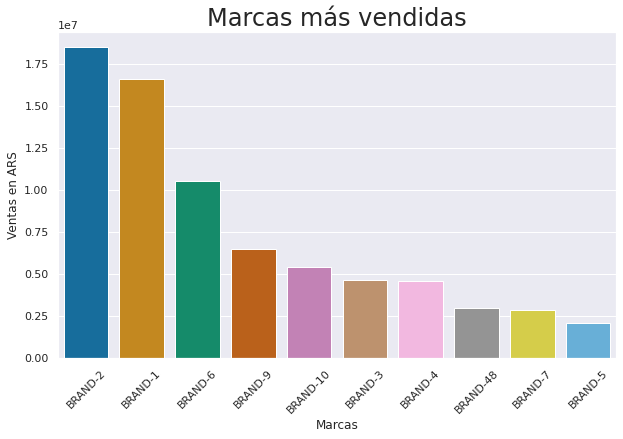

In [30]:
color = (sns.color_palette("colorblind"))
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='BRAND', y ='Sales ARS', data = mas_vendidas, palette=color)
plt.xticks(rotation=45)
plt.xlabel('Marcas')
plt.ylabel('Ventas en ARS')
plt.title('Marcas más vendidas', fontdict = {'fontsize' : 24})
plt.show()

In [31]:
m_v = (df.groupby(['BRAND']).agg({'Sales ARS':
                                           'sum'}).reset_index()).sort_values(
                                               'Sales ARS', ascending=False)
                                           
                                           
fig = px.bar(m_v, x='BRAND', y ='Sales ARS',color='BRAND')
fig.update_layout(showlegend=False)
fig.show()

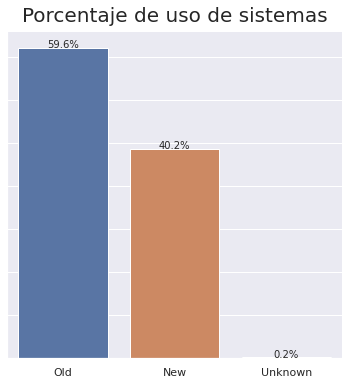

In [32]:
count_plot_vertical(df['SYSTEM'], 'SYSTEM', df, ylabel='', title='Porcentaje de uso de sistemas', pad=10)

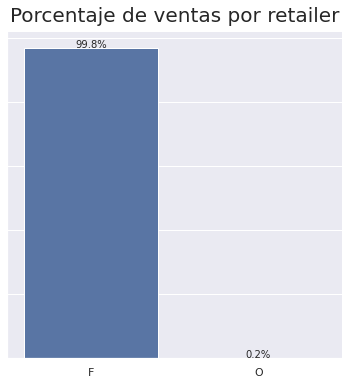

In [33]:
count_plot_vertical(df['RETAILER'], 'RETAILER', df, ylabel='', title='Porcentaje de ventas por retailer', pad=10)

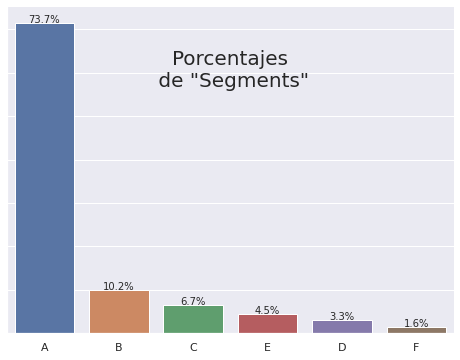

In [34]:
count_plot_vertical(df['Segment'], 'Segment', df, 
                    ylabel='', tamano=(8, 6), pad=-80,
                    title='Porcentajes\n de "Segments"')

In [35]:
fig = px.histogram(df, x="Segment", height=400, width=600, color='Segment')
fig.update_layout(showlegend=False)
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

In [36]:
#ax, fig = plt.subplots(figsize=(9,6))
#sns.countplot(x="Subsegment", data=df)
#plt.ylabel('')
#plt.show()

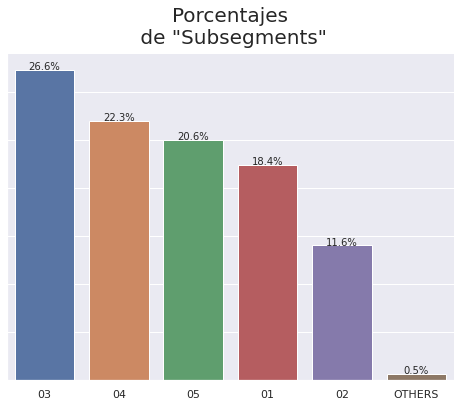

In [37]:
count_plot_vertical(df['Subsegment'], 'Subsegment', df, ylabel='', 
                    tamano=(8,6), title='Porcentajes\n de "Subsegments"',
                    pad=10)

Venta de marcas por provincias

In [38]:
a = df[['PROVINCE', 'BRAND', 'Sales ARS']]
a.head()

,PROVINCE,BRAND,Sales ARS
0,BUENOS AIRES,BRAND-1,7702.772260
1,BUENOS AIRES,BRAND-1,6511.058545
2,BUENOS AIRES,BRAND-1,4293.800075
3,BUENOS AIRES,BRAND-1,4994.754164
4,BUENOS AIRES,BRAND-1,3585.849960


In [39]:
a_2 = a.groupby(['PROVINCE', 'BRAND']).sum('Sales ARS')

In [40]:
a_2.head()

Sales ARS
PROVINCE   BRAND                 
BS.AS. GBA BRAND-1   1.962992e+06
           BRAND-10  5.402023e+05
           BRAND-11  1.060310e+05
           BRAND-12  1.795395e+05
           BRAND-14  1.972719e+05

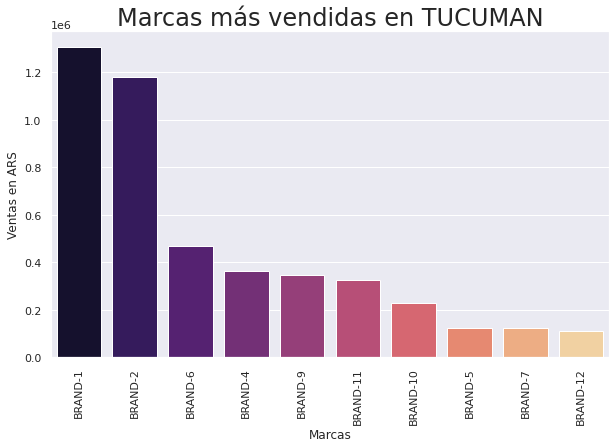

In [41]:
mas_vendidas_provincia('TUCUMAN')

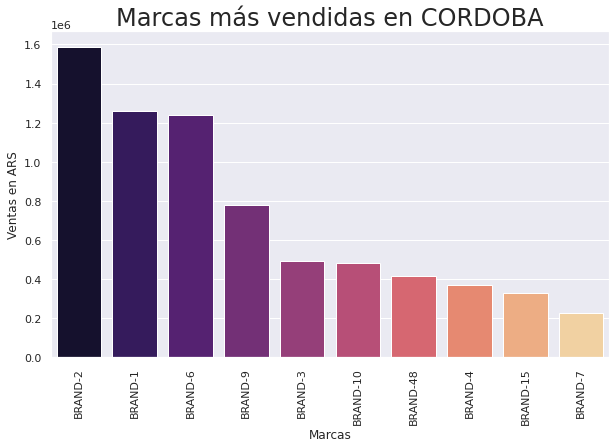

In [42]:
mas_vendidas_provincia('CORDOBA')

#### Ventas en pesos y dólares

##### Ventas en pesos

In [43]:
provincias = pd.DataFrame(df.groupby(['PROVINCE', 'Year', 'Month']).agg
                          ({'Sales ARS': 'sum', 'Sales USD': 'sum'}).reset_index())
provincias.columns = ["".join(a) for a in provincias.columns.to_flat_index()]
provincias.head()

,PROVINCE,Year,Month,Sales ARS,Sales USD
0,BS.AS. GBA,2019,December,578984.252938,9625.287938
1,BS.AS. GBA,2019,November,475567.988027,7964.463632
2,BS.AS. GBA,2019,October,598674.533508,10354.048343
3,BS.AS. GBA,2020,April,52480.381533,814.121383
4,BS.AS. GBA,2020,August,319984.835400,4407.782142


In [44]:
provincias['Fecha'] = provincias['Month']+' ' + (provincias['Year'].astype(str))
provincias['Fecha'] = pd.to_datetime(provincias['Fecha'])
provincias = provincias.drop(columns=['Year', 'Month'])
provincias = provincias[[ 'Fecha', 'PROVINCE', 'Sales ARS', 'Sales USD']]
provincias.head()

,Fecha,PROVINCE,Sales ARS,Sales USD
0,2019-12-01,BS.AS. GBA,578984.252938,9625.287938
1,2019-11-01,BS.AS. GBA,475567.988027,7964.463632
2,2019-10-01,BS.AS. GBA,598674.533508,10354.048343
3,2020-04-01,BS.AS. GBA,52480.381533,814.121383
4,2020-08-01,BS.AS. GBA,319984.835400,4407.782142


In [45]:
prov = provincias.pivot(index='PROVINCE', columns='Fecha', values='Sales ARS')
prov.columns.to_flat_index()
#prov.head()
pro = provincias.pivot(index='Fecha',columns='PROVINCE')
prov.head()

Fecha,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01
PROVINCE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BS.AS. GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598674.533508,475567.988027,578984.252938,618429.743001,510888.426666,331291.447824,52480.381533,189792.122975,233609.434630,312111.615630,319984.835400,374760.651036,717059.439145,676052.314635,1.048753e+06,997005.450725,693481.331643
BS.AS. INTERIOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,444743.407165,363276.169242,394279.463693,436206.788327,310012.123659,202990.181599,69600.860377,186765.394126,336848.088226,367404.810401,311781.926565,357638.310749,662003.381249,451138.977309,9.989335e+05,773425.943643,559300.659791
BUENOS AIRES,194262.246916,127349.009919,105836.092528,95196.826398,102689.791651,87804.656890,127060.731219,110728.321425,113017.629591,177440.452914,169297.608654,258590.022220,266482.566022,222892.760464,215513.149398,180775.050414,194425.685961,145597.728586,139221.911377,133175.439181,140931.970055,204953.337062,150422.144602,252691.014972,484080.481992,289980.832558,293685.19178,241738.934455,421996.590067,292321.192446,435715.843456,432438.130595,648004.564178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CABA ARGENTINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,422657.154832,353419.848610,431277.330745,404358.545160,163104.725053,227331.475245,189298.840935,212903.782907,231496.078425,180304.928670,121183.335420,24684.768630,76552.439824,80528.342865,79165.934010,114062.423865,145181.529990,277395.928215,212552.606430,2.571073e+05,320798.815729,233827.987980
CAP. FED. Y GBA,535653.728993,335520.806276,283083.091251,250016.378579,310340.561096,256750.985114,365169.838583,307840.268235,342107.826271,473703.965068,343348.842966,514911.130654,546680.357154,409687.898885,383368.515401,334545.236506,421472.206269,265219.792151,371120.982696,320103.078525,307574.328652,463992.305163,299839.780852,440942.945201,499990.533151,362335.862292,350829.35811,294379.110135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


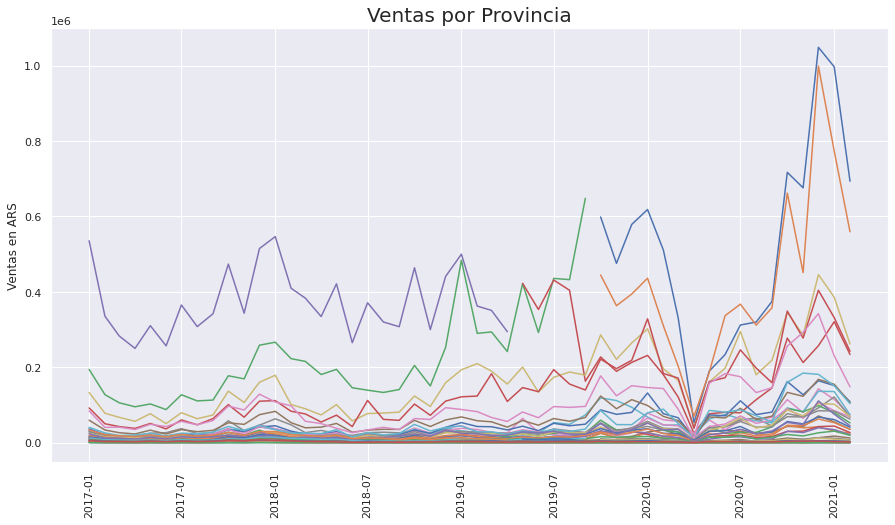

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(pro)
plt.xticks(rotation=90)
plt.ylabel('Ventas en ARS')
plt.title('Ventas por Provincia', fontdict = {'fontsize' : 20})
plt.show()

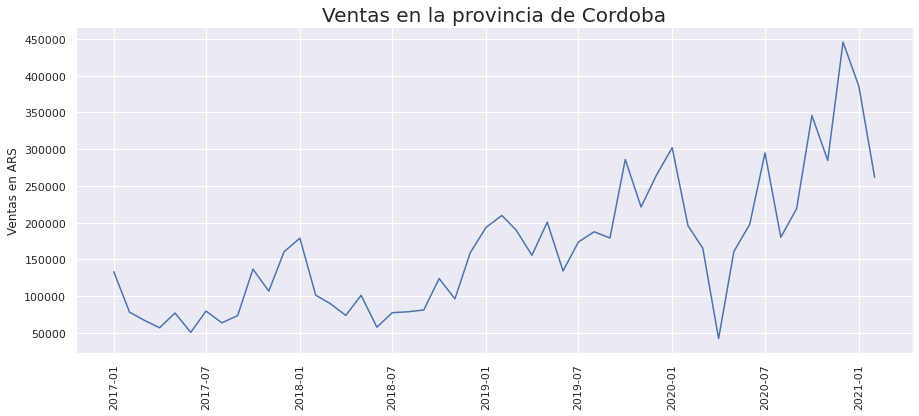

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(prov.loc['CORDOBA'])
plt.xticks(rotation=90)
plt.ylabel('Ventas en ARS')
plt.title('Ventas en la provincia de Cordoba', fontdict = {'fontsize' : 20})
plt.show()

In [48]:
df['PROVINCE'].unique()

array(['BUENOS AIRES', 'CAP. FED. Y GBA', 'CATAMARCA', 'CHACO', 'CHUBUT',
       'CORDOBA', 'ENTRE RIOS', 'LA PAMPA', 'LA RIOJA', 'MENDOZA',
       'MISIONES', 'NEUQUEN', 'RIO NEGRO', 'SAN JUAN', 'SAN LUIS',
       'SANTA CRUZ', 'SANTA FE', 'SANTIAGO DEL ES', 'CORRIENTES',
       'FORMOSA', 'JUJUY', 'SALTA', 'TUCUMAN', 'TIERRA DEL FUEG',
       'CABA ARGENTINA', 'BS.AS. GBA', 'BS.AS. INTERIOR'], dtype=object)

In [49]:
lista = ['BUENOS AIRES', 'CAP. FED. Y GBA', 'CATAMARCA', 'CHACO', 'CHUBUT',
       'CORDOBA', 'ENTRE RIOS']

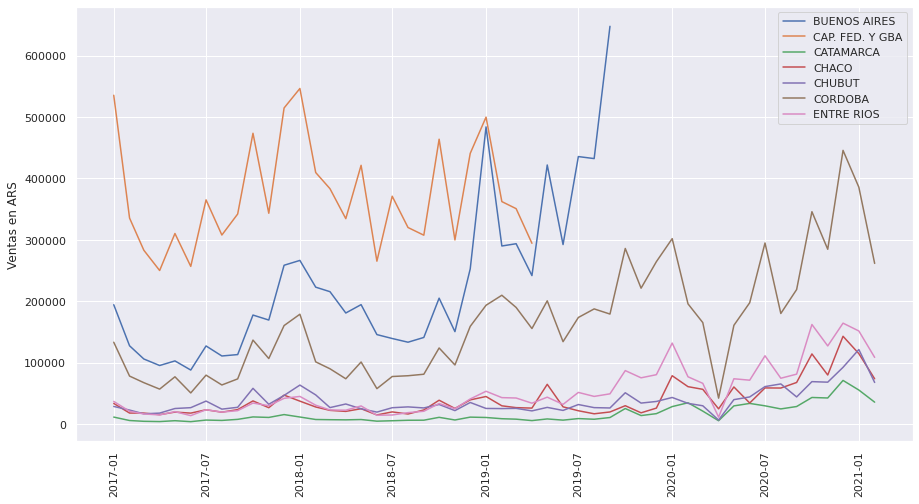

In [50]:
# Plot de serie temporal según una lista de provincias
fig, ax = plt.subplots(figsize=(15, 8))
for l in lista:
  plt.plot(prov.loc[f'{l}'])
plt.xticks(rotation=90)
plt.ylabel('Ventas en ARS')
plt.legend(lista)
plt.show()

Ventas totales

En dólares

In [51]:
p_1 = pd.DataFrame(provincias.groupby(['Fecha']).agg
                          ({'Sales USD': 'sum'})).reset_index()
p_1.columns = ['Fecha', 'Sales USD']
p_1.head()

,Fecha,Sales USD
0,2017-01-01,95249.353293
1,2017-02-01,57983.044621
2,2017-03-01,50595.458693
3,2017-04-01,44658.396556
4,2017-05-01,56657.135546


In [52]:
fig = px.line(p_1, x='Fecha', y="Sales USD", height=500, title='Ventas en USD')
fig.show()

## Ventas por fecha

In [53]:
units = pd.DataFrame(df.groupby(['PROVINCE', 'Year', 'Month']).agg
                          ({'Sales Units': 'sum'}).reset_index())
units.columns = ["".join(a) for a in units.columns.to_flat_index()]
units.head()

,PROVINCE,Year,Month,Sales Units
0,BS.AS. GBA,2019,December,16907.883587
1,BS.AS. GBA,2019,November,13868.237700
2,BS.AS. GBA,2019,October,17073.252700
3,BS.AS. GBA,2020,April,1418.415000
4,BS.AS. GBA,2020,August,6781.500000


In [54]:
units['Fecha'] = units['Month']+' ' + (units['Year'].astype(str))
units['Fecha'] = pd.to_datetime(units['Fecha'])
units = units.drop(columns=['Year', 'Month'])
units = units[[ 'Fecha', 'PROVINCE', 'Sales Units']]
units.head()

,Fecha,PROVINCE,Sales Units
0,2019-12-01,BS.AS. GBA,16907.883587
1,2019-11-01,BS.AS. GBA,13868.237700
2,2019-10-01,BS.AS. GBA,17073.252700
3,2020-04-01,BS.AS. GBA,1418.415000
4,2020-08-01,BS.AS. GBA,6781.500000


In [55]:
un = pd.DataFrame(units.groupby(['Fecha']).agg
                          ({'Sales Units': 'sum'})).reset_index()
un.columns = ['Fecha', 'Sales Units']
un.head()

,Fecha,Sales Units
0,2017-01-01,129128.309143
1,2017-02-01,81913.637671
2,2017-03-01,69323.795357
3,2017-04-01,59471.649986
4,2017-05-01,74733.183166


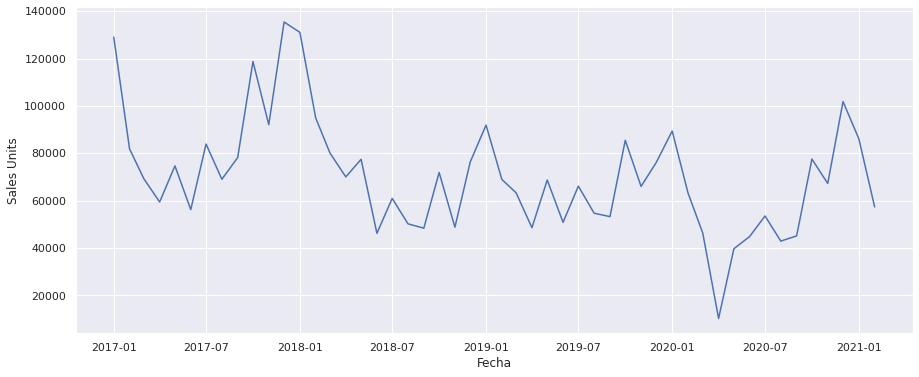

In [56]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Fecha', y='Sales Units', data=un)
plt.show()

In [57]:
fig = px.line(un, x='Fecha', y="Sales Units", height=500, title='Unidades vendidas')
fig.show()

In [58]:
un['year'] = un['Fecha'].dt.year

In [59]:
un.head()

,Fecha,Sales Units,year
0,2017-01-01,129128.309143,2017
1,2017-02-01,81913.637671,2017
2,2017-03-01,69323.795357,2017
3,2017-04-01,59471.649986,2017
4,2017-05-01,74733.183166,2017


In [60]:
anio = un[['Sales Units', 'year']].groupby('year').sum().reset_index()
anio.head()

,year,Sales Units
0,2017,1.048599e+06
1,2018,8.569647e+05
2,2019,7.947382e+05
3,2020,6.825516e+05
4,2021,1.435738e+05


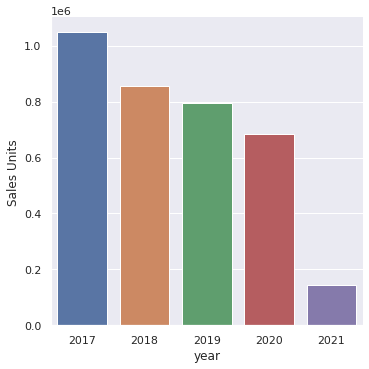

In [61]:
sns.catplot(x='year', y='Sales Units', data=anio, kind='bar')

#### Regresión lineal simple

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
un.head()

,Fecha,Sales Units,year
0,2017-01-01,129128.309143,2017
1,2017-02-01,81913.637671,2017
2,2017-03-01,69323.795357,2017
3,2017-04-01,59471.649986,2017
4,2017-05-01,74733.183166,2017


In [64]:
un = un.drop(['year'], axis=1)
un['Tiempo'] = np.arange(1, 51, 1)
un['mes'] = un['Fecha'].dt.month_name()
un.head()

,Fecha,Sales Units,Tiempo,mes
0,2017-01-01,129128.309143,1,January
1,2017-02-01,81913.637671,2,February
2,2017-03-01,69323.795357,3,March
3,2017-04-01,59471.649986,4,April
4,2017-05-01,74733.183166,5,May


In [65]:
#un.tail()

In [66]:
# Split train-test
train_size = int(un.shape[0]*0.75)
train_size


37

In [67]:
#un.head(37)

In [68]:
# Separamos en train y test
df_train, df_test = un[:train_size], un[train_size:] 
df_train.shape, df_test.shape

((37, 4), (13, 4))

In [69]:
# Separar por variables
# Train
x_train = df_train[['Tiempo']].values # Los dos corchetes es para que mantenga la forma que necesitamos
y_train = df_train['Sales Units']

print(x_train.shape, y_train.shape)
# Test
x_test = df_test[['Tiempo']].values 
y_test = df_test['Sales Units']

print(x_test.shape, y_test.shape)

(37, 1) (37,)
(13, 1) (13,)


In [70]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
y_pred = lr.predict(x_train)

In [72]:
y_futuro_pred = lr.predict(x_test)

In [73]:
# Intervalo de confianza (para un 95% de confianza, z = 1.96)
# media +- margen de error
error = y_train - y_pred
lr_desv_est = error.std()
ME = 1.96 * lr_desv_est # MArgen de error
ME

42664.01830605978

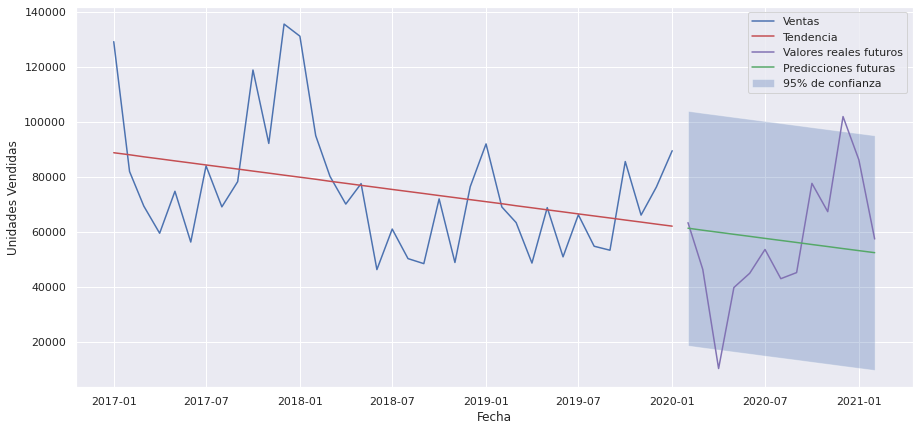

In [74]:
plt.figure(figsize=(15,7))
plt.plot(df_train['Fecha'], y_train)
plt.plot(df_train['Fecha'], y_pred, 'r')
#predicciones
plt.plot(df_test['Fecha'], y_test, 'm')
plt.plot(df_test['Fecha'], y_futuro_pred, 'g')
# Margen de error
ci_mas = y_futuro_pred + ME
ci_menos = y_futuro_pred - ME
plt.fill_between(df_test['Fecha'], (ci_mas), (ci_menos), alpha=.3)

plt.legend(['Ventas', 'Tendencia', 'Valores reales futuros', 'Predicciones futuras', '95% de confianza'])
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')

plt.show()

In [75]:
df_test

,Fecha,Sales Units,Tiempo,mes
37,2020-02-01,63323.26500,38,February
38,2020-03-01,46304.50020,39,March
39,2020-04-01,10282.42500,40,April
40,2020-05-01,39734.99625,41,May
41,2020-06-01,44924.29710,42,June
42,2020-07-01,53577.60000,43,July
43,2020-08-01,42949.05750,44,August
44,2020-09-01,45169.47000,45,September
45,2020-10-01,77608.86750,46,October
46,2020-11-01,67312.18500,47,November


In [76]:
# Predicciones 2020-10-01 77608.86750 	46 	
pred_media = lr.predict(np.array([[46]]))
print('Predicción estimada: ',int(pred_media))
print('Rango de valores posibles: ',int(pred_media - ME),'-', int(pred_media + ME))

Predicción estimada:  55377
Rango de valores posibles:  12713 - 98041


#### Modelo Aditivo

In [77]:
df_train.head()

,Fecha,Sales Units,Tiempo,mes
0,2017-01-01,129128.309143,1,January
1,2017-02-01,81913.637671,2,February
2,2017-03-01,69323.795357,3,March
3,2017-04-01,59471.649986,4,April
4,2017-05-01,74733.183166,5,May


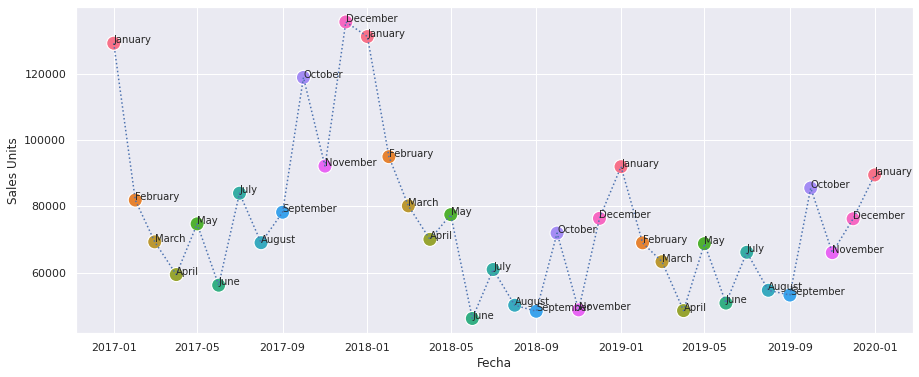

In [78]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['Fecha'], df_train['Sales Units'], 'b:')
sns.scatterplot('Fecha', 'Sales Units', data=df_train, s=200,hue='mes', legend=None)
for i in range(len(df_train)):
  plt.text(df_train['Fecha'][i], df_train['Sales Units'][i], df_train['mes'][i])

plt.show()

In [79]:
# Dummy variables. n=12 (cantidad de meses), necesito n-1 Dummy Variables
dummy = pd.get_dummies(df_train['mes'], drop_first=True)
df_train1 = df_train.copy()
df_train1 = pd.concat((df_train1, dummy), axis=1)
df_train1.head()

,Fecha,Sales Units,Tiempo,mes,August,December,February,January,July,June,March,May,November,October,September
0,2017-01-01,129128.309143,1,January,0,0,0,1,0,0,0,0,0,0,0
1,2017-02-01,81913.637671,2,February,0,0,1,0,0,0,0,0,0,0,0
2,2017-03-01,69323.795357,3,March,0,0,0,0,0,0,1,0,0,0,0
3,2017-04-01,59471.649986,4,April,0,0,0,0,0,0,0,0,0,0,0
4,2017-05-01,74733.183166,5,May,0,0,0,0,0,0,0,1,0,0,0


In [80]:
dummy = pd.get_dummies(df_test['mes'])
df_test1 = df_test.copy()
df_test1 = pd.concat((df_test1, dummy), axis=1)
df_test1.head()

,Fecha,Sales Units,Tiempo,mes,April,August,December,February,January,July,June,March,May,November,October,September
37,2020-02-01,63323.26500,38,February,0,0,0,1,0,0,0,0,0,0,0,0
38,2020-03-01,46304.50020,39,March,0,0,0,0,0,0,0,1,0,0,0,0
39,2020-04-01,10282.42500,40,April,1,0,0,0,0,0,0,0,0,0,0,0
40,2020-05-01,39734.99625,41,May,0,0,0,0,0,0,0,0,1,0,0,0
41,2020-06-01,44924.29710,42,June,0,0,0,0,0,0,1,0,0,0,0,0


In [81]:
#Dividir en X e Y
cols = ['Tiempo', 'August', 	'December', 	'February', 	'January', 	
        'July', 	'June',	'March', 	'May', 	'November', 	'October', 	'September']

In [82]:
x_train_add, x_test_add, y_train_add, y_test_add = df_train1[cols].values, df_test1[cols].values, df_train1['Sales Units'].values, df_test1['Sales Units'].values

print(x_train_add.shape, x_test_add.shape, y_train_add.shape, y_test_add.shape)

(37, 12) (13, 12) (37,) (13,)


In [83]:
lr_add = LinearRegression()
lr_add.fit(x_train_add, y_train_add)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
# Fiteo
y_pred_add = lr_add.predict(x_train_add)
#Predigo
y_futuro_add = lr_add.predict(x_test_add)

In [85]:
#Calculo el error, el desvíío, y el margen de error
error_add = y_train_add - y_pred_add
desv_est = error.std()
ME = 1.96 * desv_est 
#print('Error: ', error_add)
print('Desvío estándar: ', desv_est)
print('Margen de Error: ', ME)

Desvío estándar:  21767.35627860193
Margen de Error:  42664.01830605978


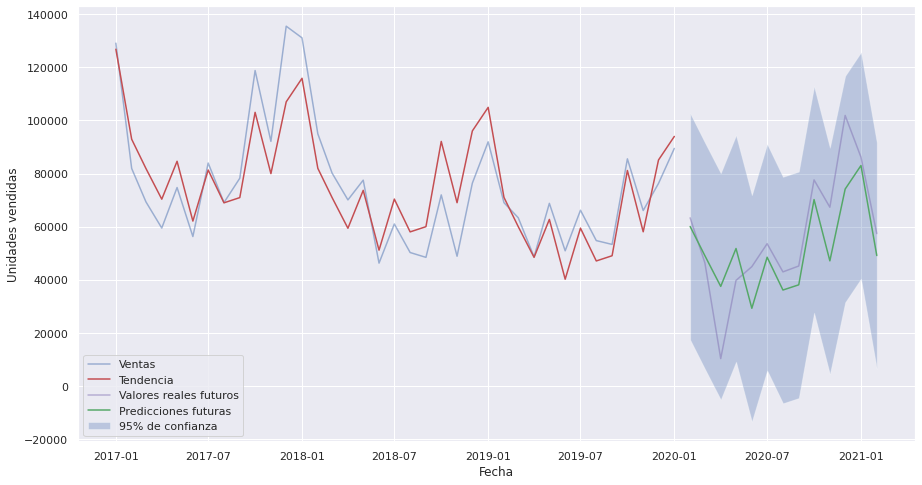

In [86]:
plt.figure(figsize=(15,8))
plt.plot(df_train1['Fecha'], y_train_add, alpha=.5)
plt.plot(df_train1['Fecha'], y_pred_add, 'r')
#predicciones
plt.plot(df_test1['Fecha'], y_test_add, 'm', alpha=.5)
plt.plot(df_test1['Fecha'], y_futuro_add, 'g')
# Margen de error
ci_mas = y_futuro_add + ME
ci_menos = y_futuro_add - ME
plt.fill_between(df_test1['Fecha'], (ci_mas), (ci_menos), alpha=.3)

plt.legend(['Ventas', 'Tendencia', 'Valores reales futuros', 'Predicciones futuras', '95% de confianza'], 
           loc='lower left')

plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.show()

#### Modelo Autoregresivo

In [87]:
df_train.tail()

,Fecha,Sales Units,Tiempo,mes
32,2019-09-01,53301.377574,33,September
33,2019-10-01,85539.475512,34,October
34,2019-11-01,66070.104171,35,November
35,2019-12-01,76274.990940,36,December
36,2020-01-01,89469.868500,37,January


En los siguientes gráficos se observa claramente la estacionalidad de los datos


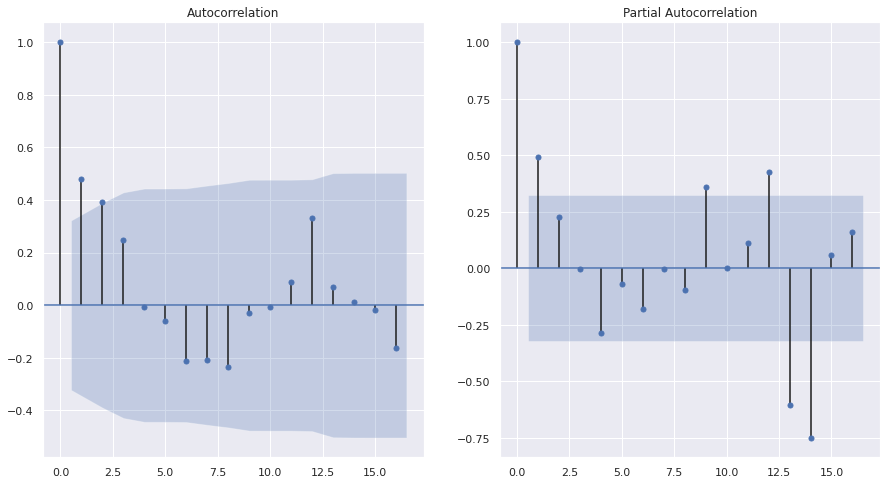

In [88]:
print('En los siguientes gráficos se observa claramente la estacionalidad de los datos')
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
res1 = plot_acf(df_train['Sales Units'], ax=ax[0])
res2 = plot_pacf(df_train['Sales Units'], ax=ax[1])
plt.show()

En el gráfico de **Autocorrelación** veo un decaimiento de los valores, que de a poco tienden a cero (se podrían ver mejor si hacemos el lag más grande).
Esto me dice que probablemente esté tratando con un problema de *Autoregresión*.


En el gráfico de **Autocorrelación parcial** me fijo en los valores que se encuentran por fuera de la banda azul (diferencias estadísticamente significativas) y en base a esos valores elijo mi *lag*.


Ahora hago que los datos sean estacionarios (centrados en cero) usando la diferencia.

In [89]:
diferencia = df_train['Sales Units'].diff()
#diferencia

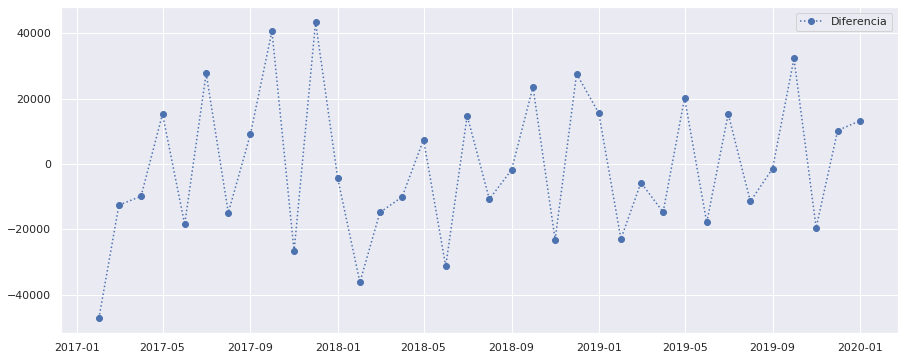

In [90]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['Fecha'], diferencia,'o:')

plt.legend(['Diferencia'])
plt.show()

In [91]:
diferencia.dropna(inplace=True)

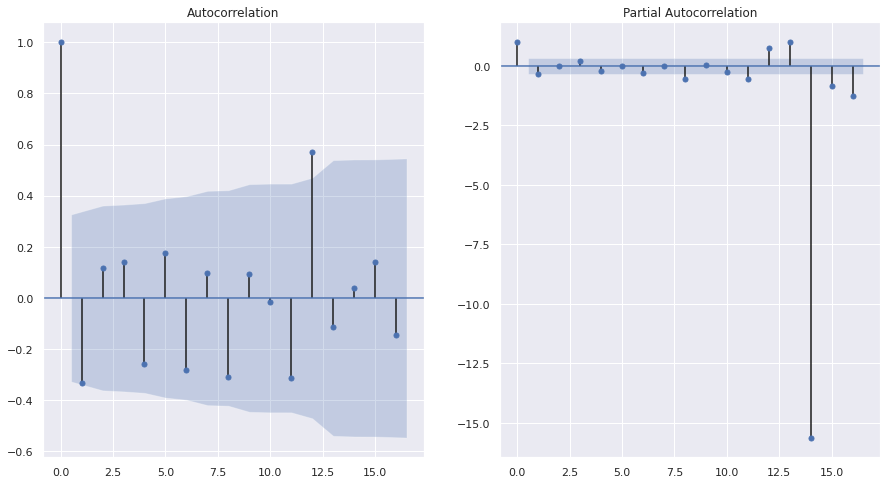

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
res1 = plot_acf(diferencia, ax=ax[0])
res2 = plot_pacf(diferencia, ax=ax[1])
plt.show()

AR(12)

In [93]:
df_train2 = df_train.drop(['Tiempo', 'mes'], axis=1)
x_train_ar = df_train2.set_index('Fecha')
#x_train_ar

In [94]:
df_test2 = df_test.drop(['Tiempo', 'mes'], axis=1)
x_test_ar = df_test2.set_index('Fecha')
#x_test_ar

In [95]:
ar = AutoReg(x_train_ar, lags=12).fit()

In [96]:
#print(ar.summary())

In [97]:
fittedvalues = ar.fittedvalues

In [98]:
fittedvalues.head()

Fecha
2018-01-01    121882.268701
2018-02-01     98737.129268
2018-03-01     82503.962412
2018-04-01     65159.438471
2018-05-01     71912.793112
dtype: float64

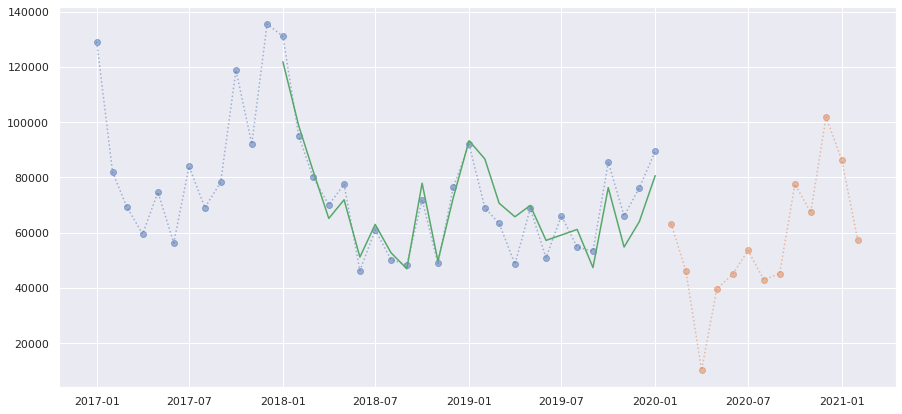

In [99]:
plt.figure(figsize=(15, 7))
plt.plot(df_train['Fecha'], df_train['Sales Units'], 'o:', alpha=.5)
plt.plot(df_test['Fecha'], df_test['Sales Units'], 'o:', alpha=.5)
#fitted values
plt.plot(fittedvalues, 'g-')

plt.show()

In [100]:
# Para hacer las predicciones
inicio = datetime.datetime.strptime('2020-02-01', '%Y-%m-%d')
final = datetime.datetime.strptime('2021-02-01', '%Y-%m-%d')
predicciones = ar.predict(inicio, final)
predicciones.head()

2020-02-01    80490.505705
2020-03-01    74517.150759
2020-04-01    60671.326991
2020-05-01    68204.905873
2020-06-01    56660.947293
Freq: MS, dtype: float64

In [101]:
#Error
ME = 1.96 * ar.resid.std()
ME

15578.886938276797

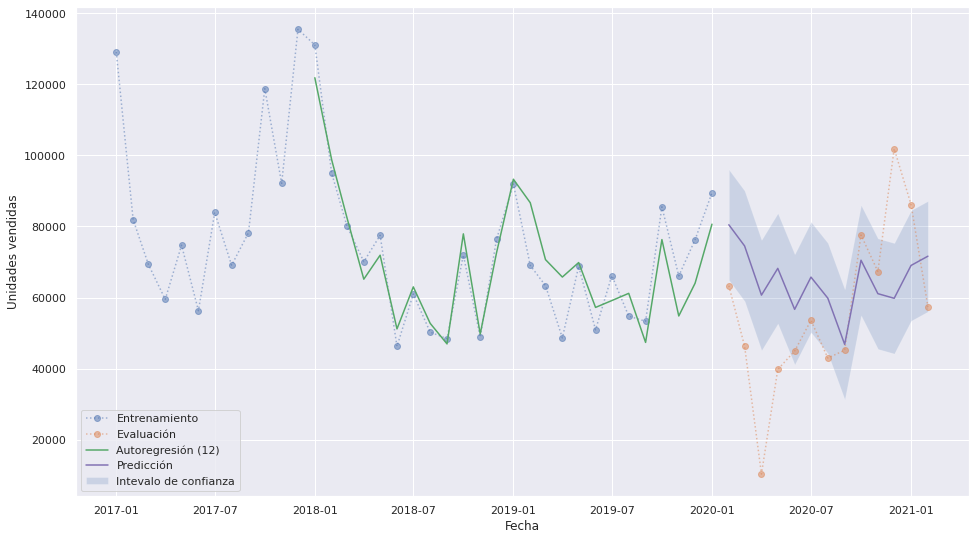

In [102]:
plt.figure(figsize=(16, 9))
plt.plot(df_train['Fecha'], df_train['Sales Units'], 'o:', alpha=.5)
plt.plot(df_test['Fecha'], df_test['Sales Units'], 'o:', alpha=.5)
#fitted values
plt.plot(fittedvalues, 'g-')
plt.plot(predicciones, 'm-')
# Intervalo de confianza
plt.fill_between(df_test['Fecha'], (predicciones.values+ME), (predicciones.values-ME), alpha=.2)

plt.legend(['Entrenamiento', 'Evaluación', 'Autoregresión (12)', 'Predicción', 'Intevalo de confianza'], loc='lower left')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.show()

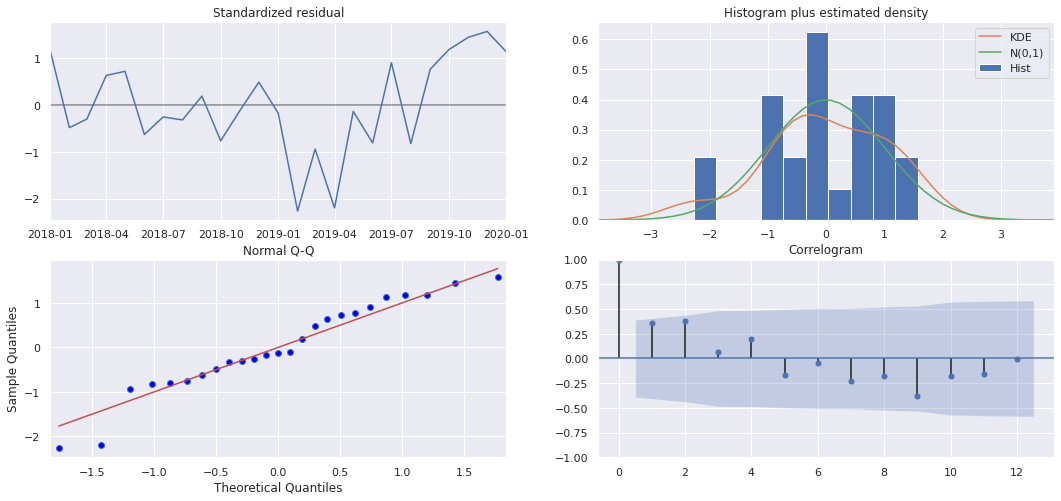

In [103]:
#Evaluación del modelo
fig = plt.figure(figsize=(18, 8))
fig = ar.plot_diagnostics(lags=12, fig=fig)

### Autoregressive Moving Average (ARMA)

In [104]:
df_train2.head()

,Fecha,Sales Units
0,2017-01-01,129128.309143
1,2017-02-01,81913.637671
2,2017-03-01,69323.795357
3,2017-04-01,59471.649986
4,2017-05-01,74733.183166


In [105]:
arima_train = df_train2.copy().set_index('Fecha')
#arima_train.head()
arima_test = df_test2.copy().set_index('Fecha')
#arima_test.head()

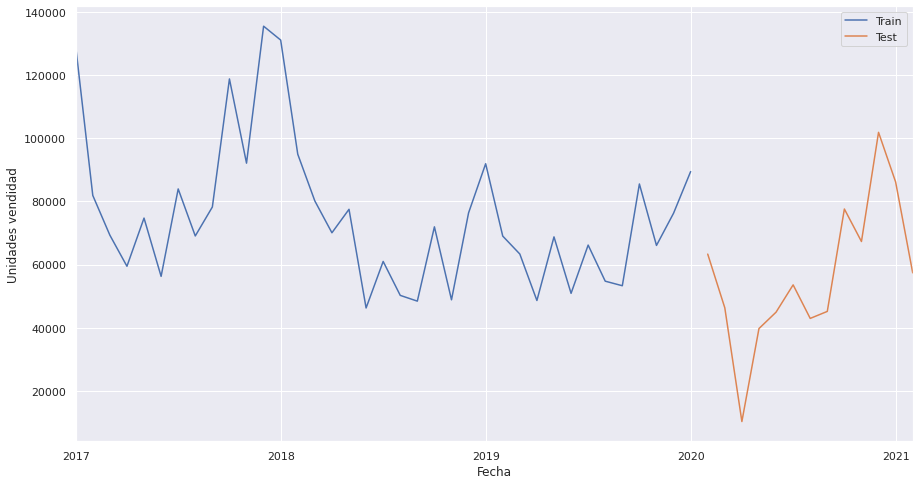

In [106]:
fig, ax = plt.subplots(figsize=(15,8))
arima_train.plot(kind='line', ax=ax)
arima_test.plot(kind='line', ax=ax)
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidad')
plt.legend(['Train', 'Test'])
plt.show()

In [107]:
from statsmodels.tsa.stattools import adfuller

In [108]:
adfuller(arima_train)

(-1.1412830966249934,
 0.6983311786633842,
 10,
 26,
 {'1%': -3.7112123008648155,
  '10%': -2.6300945562130176,
  '5%': -2.981246804733728},
 584.3008228739377)

El test de Augmented Dickey-Fuller me dice si los datos son estacionarios.

Como el segundo valor (p valor) es mayor a 0.025, sabemos que los datos no son estacionarios.

Es necesario normalizar para convertirlos.

In [109]:
estacionarios = arima_train.diff()
estacionarios.dropna(inplace=True)

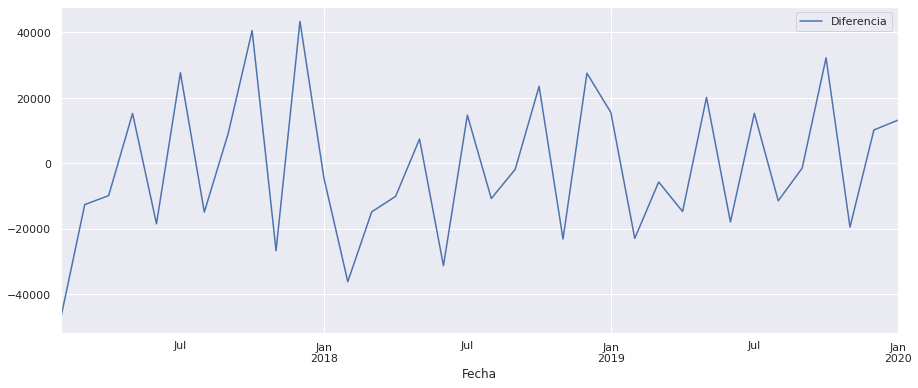

In [110]:
fig, ax = plt.subplots(figsize=(15,6))
estacionarios.plot(kind='line', ax=ax)
plt.legend(['Diferencia'])
plt.show()

In [111]:
adfuller(estacionarios)

(-4.569445584256109,
 0.0001469974374243203,
 10,
 25,
 {'1%': -3.7238633119999998, '10%': -2.6328004, '5%': -2.98648896},
 551.3125219256029)

Ahora los datos son estacionarios, por lo tanto podemos usar nuestro modelo.

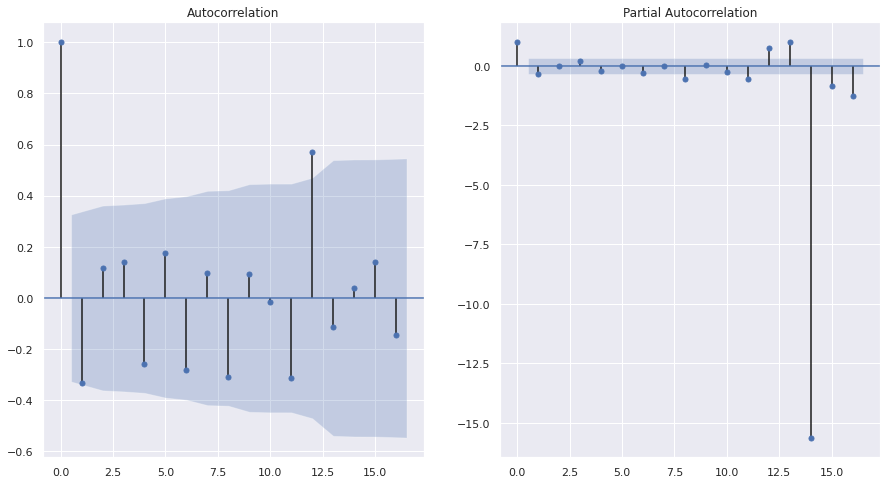

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
fig = plot_acf(estacionarios, ax=ax[0])
fig = plot_pacf(estacionarios, ax=ax[1])
plt.show()

In [113]:
p, q = 4, 4
arma = ARMA(estacionarios, order=(p,q)).fit()

In [114]:
arma.aic

819.1779227929155

In [115]:
from sklearn.metrics import mean_squared_error

In [116]:
fitted = arma.fittedvalues

In [117]:
mse = mean_squared_error(estacionarios, fitted)
print(mse)

294186133.35440457


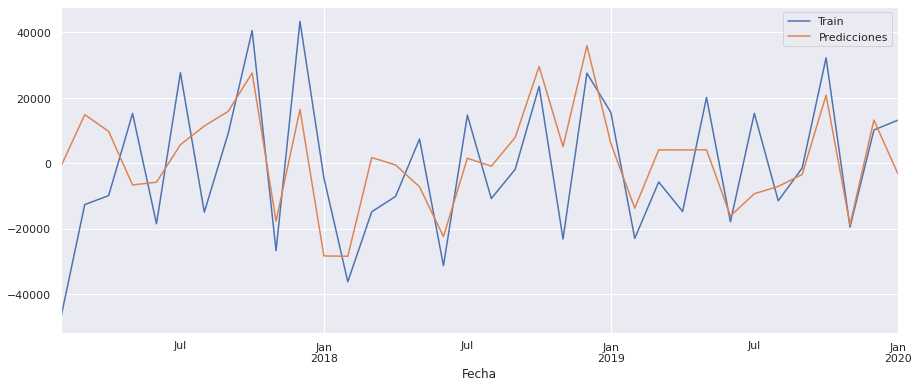

In [118]:
fig, ax = plt.subplots(figsize=(15,6))
estacionarios.plot(kind='line', ax=ax)
fitted.plot(kind='line', ax=ax)
plt.legend(['Train', 'Predicciones'])
plt.show()

In [119]:
# Para hacer las predicciones
inicio = datetime.datetime.strptime('2020-02-01', '%Y-%m-%d')
final = datetime.datetime.strptime('2021-02-01', '%Y-%m-%d')
predicciones = arma.predict(inicio, final)
predicciones.head()

2020-02-01   -17766.229046
2020-03-01   -13569.263953
2020-04-01    -1170.143241
2020-05-01   -16631.793300
2020-06-01    -2003.088077
Freq: MS, dtype: float64

In [ ]:
#fig, ax = plt.subplots(figsize=(15,6))
#estacionarios.plot(kind='line', ax=ax)
#fitted.plot(kind='line', ax=ax)
#predicciones.plot(kind='line', ax=ax)
#plt.legend(['Train', 'Predicciones'])
#plt.show()

Estas predicciones son sobre valores estacionarios, así que tengo que volver a convertirlos a su forma original

In [121]:
valor_inicial = arima_train.iloc[-1].values
#valor_inicial

In [122]:
pred = valor_inicial + predicciones.cumsum()
#pred

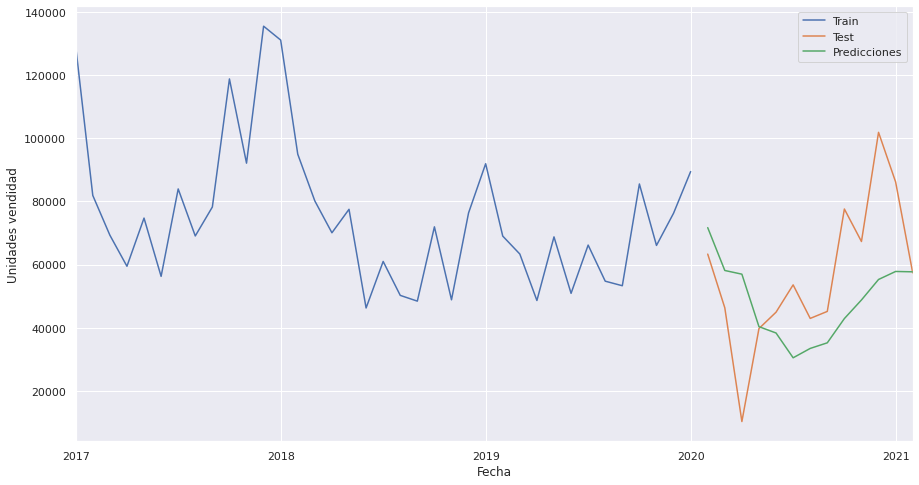

In [123]:
fig, ax = plt.subplots(figsize=(15,8))
arima_train.plot(kind='line', ax=ax)
arima_test.plot(kind='line', ax=ax)
pred.plot(kind='line', ax=ax)
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidad')
plt.legend(['Train', 'Test', 'Predicciones'])
plt.show()

### ARIMA

In [124]:
arima = ARIMA(estacionarios, order=(p, 0, q)).fit()

In [125]:
pred_arima = arima.predict(inicio, final)

In [126]:
fitted_arima = arima.fittedvalues

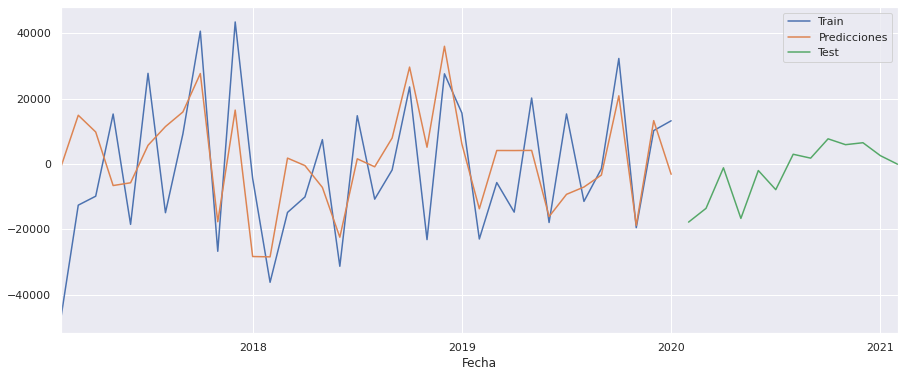

In [127]:
fig, ax = plt.subplots(figsize=(15,6))
estacionarios.plot(kind='line', ax=ax)
fitted_arima.plot(kind='line', ax=ax)
pred_arima.plot(kind='line', ax=ax)
plt.legend(['Train', 'Predicciones', 'Test'])
plt.show()

In [128]:
predicciones_arima = valor_inicial + pred_arima.cumsum()

In [129]:
len(predicciones_arima)

13

In [130]:
conf_iv = arima.forecast(steps=13)[-1]

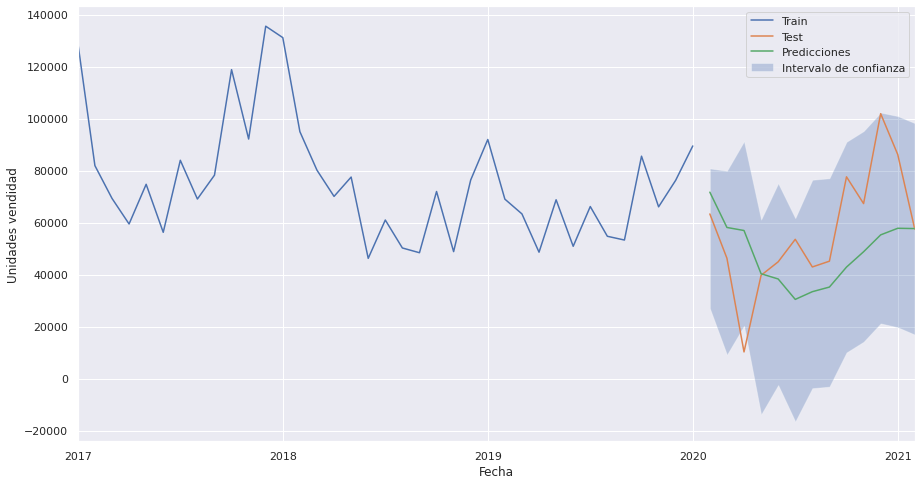

In [131]:
sup = predicciones_arima + conf_iv[:,1]
inf = predicciones_arima + conf_iv[:,0]


fig, ax = plt.subplots(figsize=(15,8))
arima_train.plot(kind='line', ax=ax)
arima_test.plot(kind='line', ax=ax)
predicciones_arima.plot(kind='line', ax=ax)

plt.fill_between(arima_test.index, inf, sup, alpha=.3)

plt.xlabel('Fecha')
plt.ylabel('Unidades vendidad')
plt.legend(['Train', 'Test', 'Predicciones', 'Intervalo de confianza'])
plt.show()

### Auto ARIMA

In [134]:
auto = auto_arima(estacionarios, start_p=12, d=0, start_q=2, max_p=24, 
                  max_d=2, max_q=24, seasonal=False, stationary=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(12,0,2)(0,0,0)[0] intercept   : AIC=804.502, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=825.188, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=822.663, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=823.943, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=823.280, Time=0.01 sec
 ARIMA(11,0,2)(0,0,0)[0] intercept   : AIC=799.737, Time=1.15 sec
 ARIMA(10,0,2)(0,0,0)[0] intercept   : AIC=809.355, Time=0.85 sec
 ARIMA(11,0,1)(0,0,0)[0] intercept   : AIC=804.149, Time=0.98 sec
 ARIMA(11,0,3)(0,0,0)[0] intercept   : AIC=801.251, Time=1.09 sec
 ARIMA(10,0,1)(0,0,0)[0] intercept   : AIC=816.849, Time=0.43 sec
 ARIMA(10,0,3)(0,0,0)[0] intercept   : AIC=810.096, Time=0.94 sec
 ARIMA(12,0,1)(0,0,0)[0] intercept   : AIC=804.680, Time=1.01 sec
 ARIMA(12,0,3)(0,0,0)[0] intercept   : AIC=805.492, Time=1.12 sec
 ARIMA(11,0,2)(0,0,0)[0]             : AIC=801.181, Time=1.00 sec

Best model:  ARIMA(11,0,2)(0,0,0)[0]

In [135]:
best_arima = ARIMA(estacionarios, (11, 1, 7)).fit() # Si pongo cero me da un error de inversión de valores. Con 1 da bien.

In [136]:
pred_best = best_arima.predict(inicio, final)

In [137]:
fitted_best = arima.fittedvalues

In [138]:
pred = valor_inicial + pred_best.cumsum()

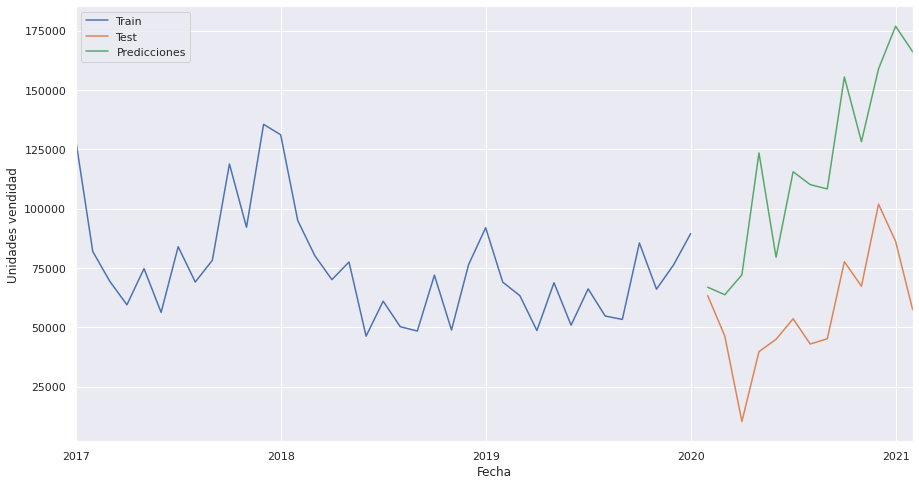

In [139]:
fig, ax = plt.subplots(figsize=(15,8))
arima_train.plot(kind='line', ax=ax)
arima_test.plot(kind='line', ax=ax)
pred.plot(kind='line', ax=ax)


plt.xlabel('Fecha')
plt.ylabel('Unidades vendidad')
plt.legend(['Train', 'Test', 'Predicciones', 'Intervalo de confianza'])
plt.show()